In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import wot
import scanpy as sc
import scvelo as scv
import cellrank as cr
import anndata as ad
from cellrank.external.kernels import WOTKernel
from cellrank.estimators import GPCCA
#from tueplots import bundles
#from tueplots import axes


In [2]:
cr.logging.print_versions()

cellrank==1.5.1+g525b847 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.5 numba==0.56.4 scipy==1.10.0 pandas==1.5.2 pygpcca==1.0.4 scikit-learn==1.2.0 statsmodels==0.13.5 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.6.2 seaborn==0.12.2


In [3]:
adata14 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_14.5_growth_rate.h5ad")
adata15 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_15.5_growth_rate.h5ad")
adata = ad.concat([adata14, adata15], merge = 'same')

adata.obs = adata.obs.loc[:, ['day', 'celltype']]
adata.var = adata.var.loc[:, ['highly_variable']]
adata.obs['celltype'] = pd.Series(adata.obs['celltype'], dtype='category')

In [4]:
adata


AnnData object with n_obs × n_vars = 20519 × 16206
    obs: 'day', 'celltype'
    var: 'highly_variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'

In [5]:
wk = WOTKernel(adata, time_key="day")
wk.compute_initial_growth_rates(organism="mouse", key_added="growth_rate_init")
wk.compute_transition_matrix(
    growth_iters=3, growth_rate_key="growth_rate_init"
)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [08:27<00:00, 507.97s/time pair]


WOTKernel[n=20519, cost_matrices=None, lambda1=1, lambda2=50, epsilon=0.05, growth_iters=3, solver='duality_gap', growth_rate_key='growth_rate_init', threshold='auto', self_transitions='connectivities']

In [6]:
g = GPCCA(wk)

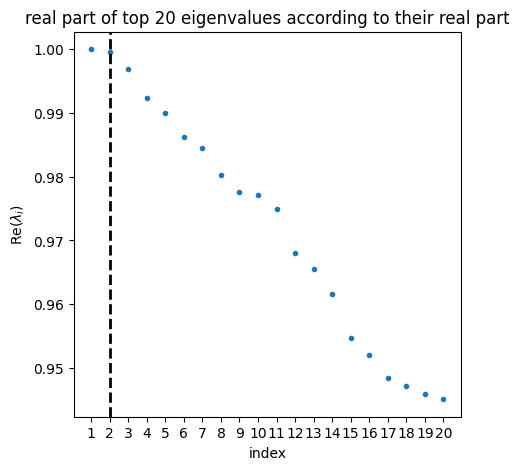

In [7]:
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

In [8]:
results = {}

In [ ]:
g.compute_macrostates(n_states=12, cluster_key="celltype")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

In [ ]:
g.compute_macrostates(n_states=13, cluster_key="celltype")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

In [ ]:
results['consistency'] = 2

In [ ]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar_1", "Acinar_2", "Acinar_3", "Acinar_4", "Acinar_5", "Ductal_1", "Ductal_2", "Alpha", "Beta", "Delta", "Epsilon"
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu', time_to_absorption='all')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

In [ ]:
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar_1", "Acinar_2", "Ductal_1", "Ductal_2", "Alpha", "Beta", "Delta", "Epsilon"],
    cluster_key='celltype',
    clusters=['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 7),
    title="",
    #save="transprobs_wot.png"
)

In [ ]:
cluster = ['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon']
terminal_cluster = ["Acinar_1", "Acinar_2", "Ductal_1", "Ductal_2", "Alpha", "Beta", "Delta", "Epsilon"]

aggregated_absorption_prob = np.empty((len(terminal_cluster), len(cluster)))
data = g.absorption_probabilities.X
sums = np.sum(data, axis=0)
tmp = adata.obs['celltype']

for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = np.dot(np.array((tmp.array==cluster[i]).astype(int)),data)
for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = aggregated_absorption_prob[:,i]/np.sum(aggregated_absorption_prob[:,i])
df = pd.DataFrame(aggregated_absorption_prob)
df.index = terminal_cluster
df.columns = cluster
df

In [ ]:
correct_transitions = [('Acinar_1', 'Acinar'), ('Acinar_2', 'Acinar'), ('Acinar_1', 'Tip'), ('Acinar_2', 'Tip'), ('Acinar_3', 'Tip'), 
                       ('Acinar_4', 'Tip'), ('Acinar_1', 'Multipotent'), ('Acinar_2', 'Multipotent'),
                       ('Ductal_1', 'Ductal'), ('Ductal_2', 'Ductal'),
                       ('Ductal_1', 'Multipotent'), ('Ductal_2', 'Multipotent'),
                       ('Alpha', 'Alpha'), ('Alpha', 'Fev+ Beta'), ('Alpha', 'Fev+ Delta'),
                       ('Alpha', 'Fev+ Alpha'), ('Alpha', 'Fev+ Epsilon'), ('Alpha', 'Ngn3 High early'),
                       ('Alpha', 'Ngn3 High late'), ('Beta', 'Beta'), ('Beta', 'Fev+ Beta'), ('Beta', 'Fev+ Delta'),
                       ('Beta', 'Fev+ Alpha'), ('Beta', 'Fev+ Epsilon'), ('Beta', 'Ngn3 High early'), 
                       ('Beta', 'Ngn3 High late'), ('Delta', 'Delta'), ('Delta', 'Fev+ Beta'), 
                       ('Delta', 'Fev+ Delta'), ('Delta', 'Fev+ Alpha'), ('Delta', 'Fev+ Epsilon'),
                       ('Delta', 'Ngn3 High early'), ('Delta', 'Ngn3 High late'), ('Epsilon', 'Epsilon'), 
                       ('Epsilon', 'Fev+ Beta'), ('Epsilon', 'Fev+ Delta'), ('Epsilon', 'Fev+ Alpha'), 
                       ('Epsilon', 'Fev+ Epsilon'), ('Epsilon', 'Ngn3 High early'), ('Epsilon', 'Ngn3 High late'), 
                       ('Alpha', 'Multipotent'),('Epsilon', 'Multipotent'), ('Beta', 'Multipotent'), 
                       ('Delta', 'Multipotent')]

sum_prob = 0
for i in correct_transitions:
    sum_prob = sum_prob + df.loc[i]
mean_prob = sum_prob/len(cluster)
mean_prob